# Unit 4: Applied Machine Learning 2
## Task 1: Data exploration and feature extraction
###### Candelaria Retamal
###### **14.06.2022**


#### 1.1. Load images
Load the images from the three sets (train, validation, and test). Since the images will be fed to a pretrained model for feature extraction, make sure to set the scale of the pixels and the image size as expected by the model (you can check the expected scale and size in the official documentation page)

---

> **Solution**: For loading the data we will use the information that may be found in the Tensorflow section. The first step is to create an ImageDataGenerator which specifies how to process each image. In our case, we will simply apply 0-1 rescaling to all images. No horizontal flip or rotation is added as we are working with a trained network that will act as a transformer.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
from IPython.display import display
import PIL.Image as Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

# Create image generator
train_generator = ImageDataGenerator(
    rescale=1 / 255)
validation_generator = ImageDataGenerator(
    rescale=1 / 255)
test_generator = ImageDataGenerator(rescale=1. / 255)

In [2]:
import os

# Train, validation and test sets
trainset = train_generator.flow_from_directory(
    os.path.join("images", "train"),
    target_size=(224, 224),
    shuffle=False,
    batch_size = 32,
    classes=["bike","car","motorcycle","other","truck","van"]
)

validset = validation_generator.flow_from_directory(
    os.path.join("images", "valid"),
    target_size=(224, 224),
    shuffle=False
)
testset = test_generator.flow_from_directory(
    os.path.join("images", "test"), target_size=(224, 224), shuffle=False
)


Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


#### 1.2. Plot images from each category 
Plot a few images from each category (bike, car, motorcycle, other, truck, van).

---

> **Solution**: For plotting the images we will iterate over the length of the trainset. We must realize that there are 9 batches in the trainset and that the dimensions of this array are: 9x32x224x224x3, where 9 corresponds to the number of batches, each one containing 32 images of 224x224 pixels in three channels (RGB). We will plot 3 images every two batches

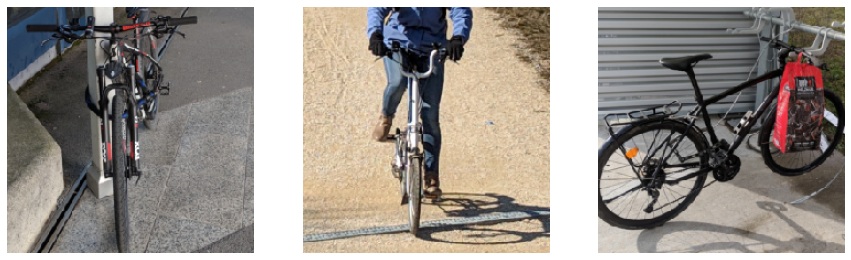

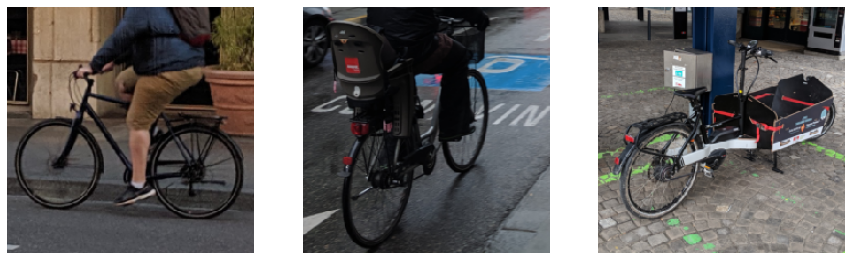

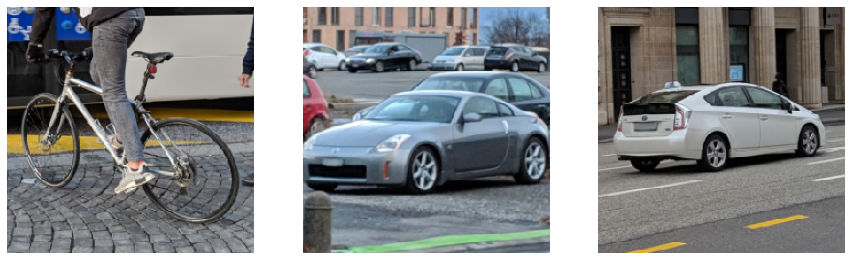

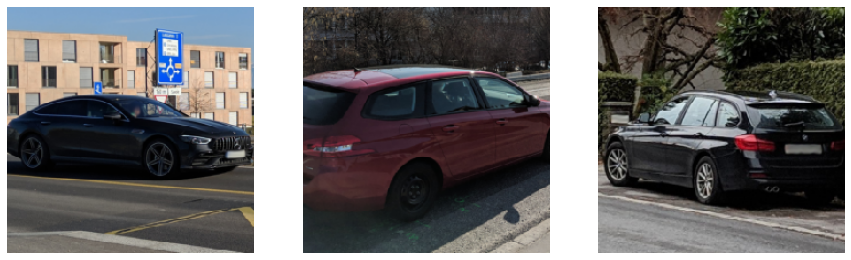

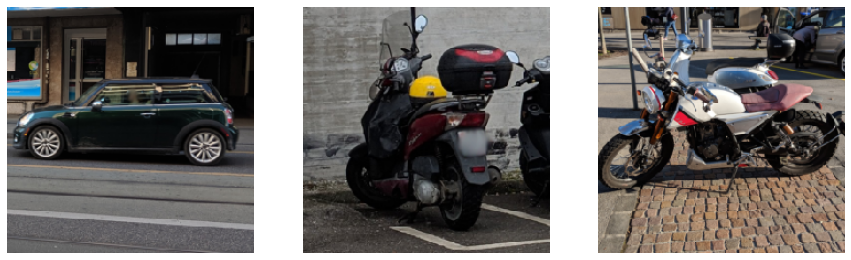

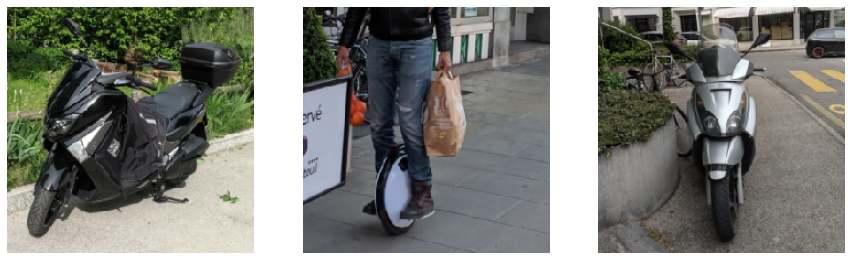

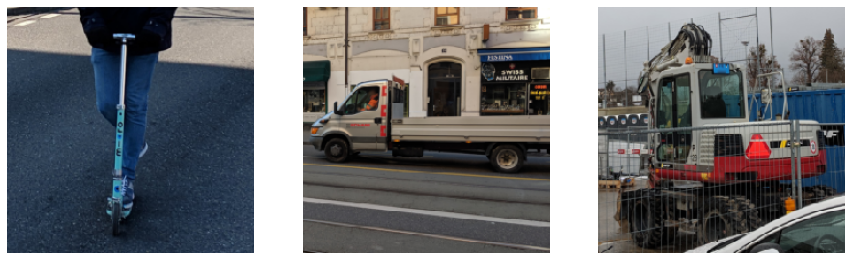

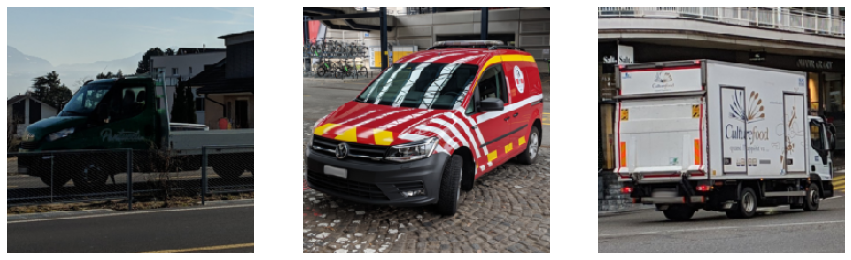

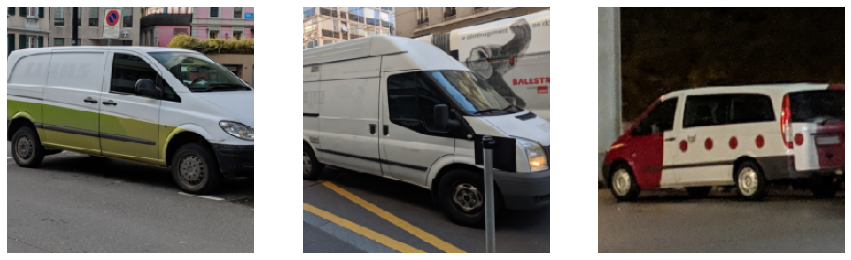

In [3]:
import matplotlib.pyplot as plt

num_batches = len(trainset)

for i in range(0,num_batches):
    img, label = trainset[i]
    rows = 1
    columns = 3
    fig = plt.figure(figsize=(15, 8))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img[0])
    plt.axis("off")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(img[-1])
    plt.axis("off")
    fig.add_subplot(rows, columns, 3)
    plt.imshow(img[16])
    plt.axis("off")
    plt.show()


#np.shape(img)
#print(label)

#### 1.3. Visualization of proportions

Use an appropriate visualization to show the proportions of each category in the three sets (train, validation, and test).

---

> **Solution**: For showing the proportions of each category in the three sets we implement a function that extracts the classes and proportion data. Afterwards, we plot the information in a multiple barplot for enhancing an easy comparison.

In [4]:
import pandas as pd
import numpy as np

def proportions(set):
    indices = list(set.class_indices.keys())
    (unique, counts) = np.unique(set.classes, return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    valores = counts * 100 / len(set.classes)
    percentages = dict(zip(indices, valores))
    return (percentages, indices, valores)

(train_percentages,train_class,train_value) = proportions(trainset)
(valid_percentages,valid_class,valid_value) = proportions(validset)
(test_percentages,test_class,test_value) = proportions(testset)
print(train_percentages)
print(valid_percentages)
print(test_percentages)

{'bike': 23.571428571428573, 'car': 22.857142857142858, 'motorcycle': 18.214285714285715, 'other': 11.428571428571429, 'truck': 15.0, 'van': 8.928571428571429}
{'bike': 23.741007194244606, 'car': 23.02158273381295, 'motorcycle': 17.985611510791365, 'other': 11.510791366906474, 'truck': 15.107913669064748, 'van': 8.633093525179856}
{'bike': 24.0, 'car': 22.0, 'motorcycle': 18.0, 'other': 12.0, 'truck': 14.0, 'van': 10.0}


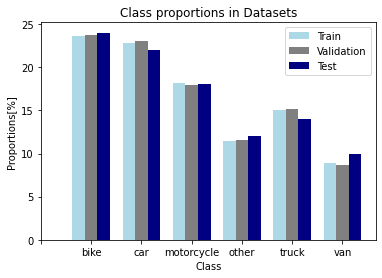

In [5]:
import numpy as np
import matplotlib.pyplot as plt

data = [train_value.tolist(),
  valid_value.tolist(),
  test_value.tolist()]

X = np.arange(1,7,1)
bar1 = plt.bar(X -0.25, data[0], color = 'lightblue', width = 0.25)
plt.legend("Train")
bar2 = plt.bar(X + 0, data[1], color = 'grey', width = 0.25)
bar3 = plt.bar(X + 0.250, data[2], color = 'navy', width = 0.25)
plt.xlabel('Class')
plt.ylabel('Proportions[%]')
plt.title('Class proportions in Datasets')
  
plt.xticks(np.arange(7),["",'bike', 'car', 'motorcycle', 'other', 'truck', 'van'])
plt.legend( (bar1, bar2, bar3), ('Train', 'Validation', 'Test') )
plt.show()


**Observations:** The plot shows that bikes and cars (~23%) present a higher level of appearances than the rest of the classes. The vans present a very low number of photos in comparison to the rest of the classes (only a 9%). It is important to take into consideration that the proportions are mainly constant for the three datsets.

#### 1.5. Extract high-level features

Extract the high-level features for all the images in the three datasets using MobileNet v2. Consider storing the extracted high-level features, e.g. in npz files, for quickly reloading them into each of the following notebooks.

---

> **Solution**: For this point the strategy is to iterate over the batches in every dataset. We create tf elements that are saved into .npz files as suggested in the question. These .tf elements contain the features and labels of each set. Finally, we plot the features and frequency for each of the three sets. These three plots are a summary of ALL of the pictures that conform each set.

In [6]:
import tensorflow as tf
import tensorflow_hub as hub

In [7]:
# Create the image feature extractor
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
feature_extractor = hub.load(model_url)

In [8]:
# extract and save high-level features in TRAINSET
from numpy import asarray
from numpy import savez_compressed
cnt = 0
trainset.reset()
val_image_batch_tr, val_label_batch_tr = next(iter(trainset))

for val_image_batch_tr, val_label_batch_tr in trainset:
    print(trainset.batch_index)
    exec(f'features_train_{cnt} = feature_extractor(val_image_batch_tr)')
    exec(f'features_labels_{cnt} = val_label_batch_tr')
    if cnt == len(trainset)-1 :
        break
    cnt += 1
features_trainset = tf.concat([features_train_8, features_train_0, 
                               features_train_1, features_train_2, features_train_3, features_train_4, features_train_5, features_train_6, features_train_7],0)
labels_trainset = tf.concat([features_labels_8, features_labels_0, features_labels_1, features_labels_2, features_labels_3, features_labels_4, features_labels_5, features_labels_6, features_labels_7],0)                              
np.savez_compressed("features_trainset.npz", data=features_trainset, label=labels_trainset)

2
3
4
5
6
7
8
0
1


In [9]:
# extract and save high-level features in VALIDSET
cnt = 0
validset.reset()
val_image_batch_v, val_label_batch_v = next(iter(validset))
for val_image_batch_v, val_label_batch_v in validset:
    print(validset.batch_index)
    exec(f'features_valid_{cnt} = feature_extractor(val_image_batch_v)')
    exec(f'labels_valid_{cnt} = val_label_batch_v')
    if cnt == len(validset)-1 :
        break
    cnt += 1
features_validset = tf.concat([features_valid_4, features_valid_0, features_valid_1, features_valid_2, features_valid_3],0)
labels_validset = tf.concat([labels_valid_4, labels_valid_0, labels_valid_1, labels_valid_2, labels_valid_3], 0)                              

np.savez_compressed("features_validset.npz",data=features_validset, label=labels_validset)

2
3
4
0
1


In [10]:
# extract and save high-level features in TESTSET
cnt = 0
testset.reset()
val_image_batch_te, val_label_batch_te = next(iter(testset))
for val_image_batch_te, val_label_batch_te in testset:
    print(testset.batch_index)
    exec(f'features_test_{cnt} = feature_extractor(val_image_batch_te)')
    exec(f'labels_test_{cnt} = val_label_batch_te')
    if cnt == len(testset)-1 :
        break
    cnt += 1
features_testset = tf.concat([ features_test_1,features_test_0],0)
labels_testset = tf.concat([labels_test_1,labels_test_0], 0)

np.savez_compressed("features_testset.npz",data=features_testset, label=labels_testset)

0
1


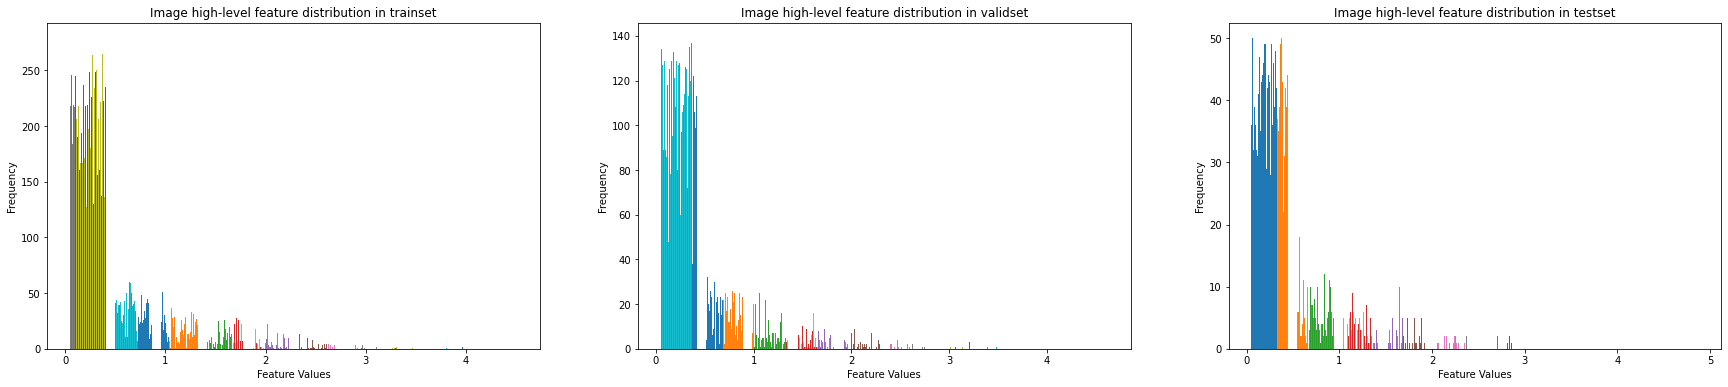

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = [30, 6]) # larger figure size for subplots

# trainset
plt.subplot(1, 3, 1) # 1 row, 3 cols, subplot 1
plt.hist(features_trainset.numpy())
plt.title("Image high-level feature distribution in trainset")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")

# validset
plt.subplot(1, 3, 2) # 1 row, 3 cols, subplot 2
plt.hist(features_validset.numpy())
plt.title("Image high-level feature distribution in validset")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")


# testset
plt.subplot(1, 3, 3) # 1 row, 3 cols, subplot 3
plt.hist(features_testset.numpy())
plt.title("Image high-level feature distribution in testset")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")

plt.show()

**Observations:** Through the summary plots of the high level features per set, we may see that most of the feature values are concentrated between 0 and 1. It is interesting to realize that there are 6 subgroups or block of feature values in each set. These 6 blocks are more visible in the trainset, which contains more images.

#### 1.7. Questions

For each of the 6 categories in the training dataset, answer the following questions:
* What are the top 5 features that have the highest mean value?
* Which categories share the same most active feature (i.e. have highest means)?

---

> **Solution**: We will first separate the trainset in the 6 available classes. This information will be stored in .npz documents. Afterwards, we will take a look at the top 5 features with highest mean, which are calculated with a tf.math function. Finally a comparison between classes will be made for choosing the categories that share the most active features

In [12]:
#for i in range(0,len(labels_trainset)):
#del bike
#del car
#del motorcycle
#del truck
#del other
#del van

for i in range(0,len(labels_trainset)):
    if labels_trainset[i].numpy()[0] == 1:
        if "bike" in locals():
            ft = tf.expand_dims(features_trainset[i], axis=0)
            bike=tf.concat([bike, ft],0)
        else:
            bike = features_trainset[i]
            bike = tf.expand_dims(bike, axis=0)
    if labels_trainset[i].numpy()[1] == 1:
        if "car" in locals():
            ft = tf.expand_dims(features_trainset[i], axis=0)
            car=tf.concat([car, ft],0)
        else:
            car = features_trainset[i]
            car = tf.expand_dims(car, axis=0)
    if labels_trainset[i].numpy()[2] == 1:
        if "motorcycle" in locals():
            ft = tf.expand_dims(features_trainset[i], axis=0)
            motorcycle=tf.concat([motorcycle, ft],0)
        else:
            motorcycle = features_trainset[i]
            motorcycle = tf.expand_dims(motorcycle, axis=0)  
            
    if labels_trainset[i].numpy()[3] == 1:
        if "other" in locals():
            ft = tf.expand_dims(features_trainset[i], axis=0)
            other=tf.concat([other, ft],0)
        else:
            other = features_trainset[i]
            other = tf.expand_dims(other, axis=0)
    
    if labels_trainset[i].numpy()[4] == 1:
        if "truck" in locals():
            ft = tf.expand_dims(features_trainset[i], axis=0)
            truck=tf.concat([truck, ft],0)
        else:
            truck = features_trainset[i]
            truck = tf.expand_dims(truck, axis=0)
    
    if labels_trainset[i].numpy()[5] == 1:
        if "van" in locals():
            ft = tf.expand_dims(features_trainset[i], axis=0)
            van=tf.concat([van, ft],0)
        else:
            van = features_trainset[i]
            van = tf.expand_dims(van, axis=0)

**Observations:** Though this loop we are separating the trainset into its different classes. For making sure that the separation was performed correctly let's take a look at the shape of each class

In [13]:
print(bike.shape)
print(van.shape)
print(car.shape)
print(motorcycle.shape)
print(other.shape)
print(truck.shape)

(66, 1280)
(25, 1280)
(64, 1280)
(51, 1280)
(32, 1280)
(42, 1280)


* The separation was succesfully accomplished. Now we will create a function that extracts the top 5 features by sorting the set through its highest mean value. We will plot the results using the same x and y scales, so that the comparison between classes may be clear.

In [14]:
def top_5(features):
    average_feature = tf.reduce_mean(features,0)
    high_indices_feature = tf.argsort(average_feature, axis = -1, direction = "DESCENDING") # axis -1 sorts the last axis (in this case 1280)
    top_values = []
    top_indices = []
    for i in range (0,5):
        top_values.append(average_feature[high_indices_feature[i]].numpy())
        top_indices.append(high_indices_feature[i].numpy())
    return(top_values,top_indices)

In [15]:
(val_bike,index_bike) = top_5(bike)
(val_car,index_car) = top_5(car)
(val_motorcycle,index_motorcycle) = top_5(motorcycle)
(val_other,index_other) = top_5(other)
(val_truck,index_truck) = top_5(truck)
(val_van,index_van) = top_5(van)

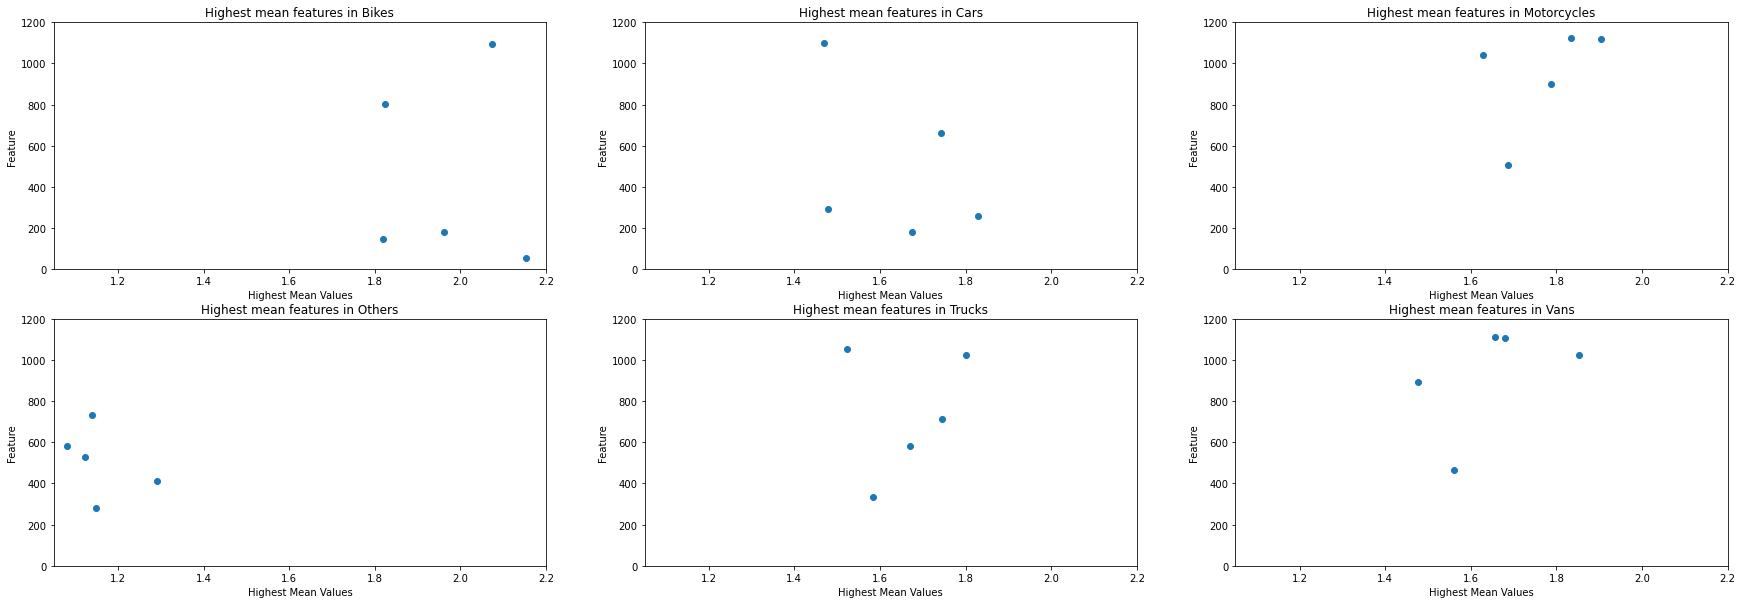

In [16]:
plt.figure(figsize = [30, 10]) # larger figure size for subplots

# trainset
plt.subplot(2, 3, 1) # 2 row, 3 cols, subplot 1
plt.scatter(val_bike,index_bike, marker='o', label='Bike')
plt.title("Highest mean features in Bikes")
plt.xlabel("Highest Mean Values")
plt.ylabel("Feature")
plt.xlim(1.05,2.2)
plt.ylim(0,1200)

plt.subplot(2, 3, 2) # 2 row, 3 cols, subplot 1
plt.scatter(val_car,index_car, marker='o', label='Car')
plt.title("Highest mean features in Cars")
plt.xlabel("Highest Mean Values")
plt.ylabel("Feature")
plt.xlim(1.05,2.2)
plt.ylim(0,1200)

plt.subplot(2, 3, 3) # 2 row, 3 cols, subplot 1
plt.scatter(val_motorcycle,index_motorcycle, marker='o', label='Motorcycle')
plt.title("Highest mean features in Motorcycles")
plt.xlabel("Highest Mean Values")
plt.ylabel("Feature")
plt.xlim(1.05,2.2)
plt.ylim(0,1200)

plt.subplot(2, 3, 4) # 2 row, 3 cols, subplot 1
plt.scatter(val_other,index_other, marker='o', label='Other')
plt.title("Highest mean features in Others")
plt.xlabel("Highest Mean Values")
plt.ylabel("Feature")
plt.xlim(1.05,2.2)
plt.ylim(0,1200)

plt.subplot(2, 3, 5) # 2 row, 3 cols, subplot 1
plt.scatter(val_truck,index_truck, marker='o', label='Truck')
plt.title("Highest mean features in Trucks")
plt.xlabel("Highest Mean Values")
plt.ylabel("Feature")
plt.xlim(1.05,2.2)
plt.ylim(0,1200)

plt.subplot(2, 3, 6) # 2 row, 3 cols, subplot 1
plt.scatter(val_van,index_van, marker='o', label='Van')
plt.title("Highest mean features in Vans")
plt.xlabel("Highest Mean Values")
plt.ylabel("Feature")
plt.xlim(1.05,2.2)
plt.ylim(0,1200)

plt.show()

**Observations** Most of the highest mean values for each class fluctuate in average between 0 and 1. It is interesting to see that the highest mean values bikes ten to be nearer to 2, whilst the highest mean values of Others tend to be nearer to 1. The main features are dispersed between all of the possible values (0-1280). But, the bikes seem to have more relevant features of low values (under 400), whilst the motorcylces and vans present more relevant features of high values (over 800).

* For having a further look, lets make a summary table that contains the top 5 features of each class

In [17]:
from itertools import zip_longest

list_1 =  [round(x,3) for x in index_bike] 
list_2 = [round(x,3) for x in index_car] 
list_3 = [round(x,3) for x in index_motorcycle]
list_4 = [round(x,3) for x in index_other] 
list_5 = [round(x,3) for x in index_truck]
list_6 = [round(x,3) for x in index_van] 


from itertools import zip_longest


header = ['BIKE', 'CAR', 'MOTORCYCLE',"OTHER","TRUCK","VAN"]

#width = 14
width = 20

row = ["  {:^{}}  ".format(item, width)
              for item in header]

print("|".join(row))

row = ["  " + "="*width + "  "
          for item in header]

print("|".join(row))


for row in zip_longest(list_1, list_2, list_3, list_4,list_5,list_6):

    # put empty string instead of `None`
    row = ["" if item is None else item
              for item in row]

    # format every item to the same length
    row = ["  {:{}}  ".format(item, width)
              for item in row]

    # join all items in row using `|` and display row
    print("|".join(row))

          BIKE          |          CAR           |       MOTORCYCLE       |         OTHER          |         TRUCK          |          VAN           
  ====================  |  ====================  |  ====================  |  ====================  |  ====================  |  ====================  
                    54  |                   257  |                  1120  |                   411  |                  1022  |                  1022  
                  1094  |                   660  |                  1122  |                   279  |                   714  |                  1104  
                   183  |                   183  |                   898  |                   734  |                   580  |                  1113  
                   801  |                   291  |                   505  |                   529  |                   335  |                   466  
                   148  |                  1098  |                  1043  |                   580  |

* For the final step, we will apply an intersection function for seeing if any features are shared by two or more classes

In [18]:
# Python program to illustrate the intersection
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [19]:
# Bikes and all the rest
print(intersection(list_1, list_2))
print(intersection(list_1, list_3))
print(intersection(list_1, list_4))
print(intersection(list_1, list_5))
print(intersection(list_1, list_6))

[183]
[]
[]
[]
[]


In [20]:
# Cars and all except bikes
print(intersection(list_2, list_3))
print(intersection(list_2, list_4))
print(intersection(list_2, list_5))
print(intersection(list_2, list_6))

[]
[]
[]
[]


In [21]:
# Motorcycle
print(intersection(list_3, list_4))
print(intersection(list_3, list_5))
print(intersection(list_3, list_6))

[]
[]
[]


In [22]:
# Other
print(intersection(list_4, list_5))
print(intersection(list_4, list_6))

[580]
[]


In [23]:
# Truck
print(intersection(list_5, list_6))

[1022]


**Observations:** We may see that bikes and cars share the feature number 183, others and trucks share the feature 580 and truck and vans share the feature 1022.

In [24]:
savez_compressed("bike_trainset.npz",bike)
savez_compressed("car_trainset.npz",car)
savez_compressed("motorcycle_trainset.npz",motorcycle)
savez_compressed("other_trainset.npz",other)
savez_compressed("truck_trainset.npz",truck)
savez_compressed("van_trainset.npz",van)

* We will also save the variables that contain the classes separated in the trainset